<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/MA573_Project_Larger_Scale_IV_Calculation_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

We are going to attempt to compute implied volatilities for the system. Import numpy, scipy.stats and pyplot for the sake of use, and clone in the proper files from my directory.

In [1]:
#!git clone https://github.com/TALeonard/19ma573thomasleonard.git #Only run once!

Cloning into '19ma573thomasleonard'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 445 (delta 56), reused 0 (delta 0), pack-reused 286
Receiving objects: 100% (445/445), 1.80 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [2]:
cd /content/19ma573thomasleonard/src/

/content/19ma573thomasleonard/src


In [0]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
import pandas as pd
from european_options_class import VanillaOption
from gbm_1d_class_v02 import Gbm

Define the "default" parameters which are true for every asset. These include:

* Otype - this is 1 for all values (I am only looking at calls for parsimony)
* Maturity - dependant on which fileset I am using. For the 4/18/2019 set, this maturty is 21 days out (I acquired this data on 3-27-2019). This doesn't count the day itself, and I will only count business days, so this is  actually 16 days (or 16/252, to convert to years).
* Interest rate - again, dependent on fileset. For 4/18/2019, r = 2.45%.

For the other data, we have the remaining information - Spot price, strike price, and (for implied volatility computation) the Option Price.

In [0]:
r = 0.0245
otype = 1
maturity = 16/252

Import the data. Each dataset is separated by maturity date.

In [0]:
df = pd.read_csv('calls_4_18_2019.csv')

stock_names = df.Stock
spot_prices = df['Stock Price']
strikes = df.Strike
true_prices = df['Option Price']
true_iv = df.IV

90

From this, we now have a set of variables which represent lists of each piece of worthwhile information from the array - the names of the underlying stocks (for reference), the spot prices used, the strikes, the observed options prices, and the related computed implied volatilities.

Now, build the list of GBMs and the list of options for use.

In [0]:
num_row = stock_names.shape[0]
gbm_list = []
option_list = []
num_data_per_stock = [] # A vector to track how many data points each GBM corresponds to
first_line = True
count = 1

for i in range(num_row):
  option1 = VanillaOption(otype = otype, strike = strikes[i],
                         maturity = maturity, market_price = true_prices[i])
  
  option_list.append(option1)
  if first_line == True:
    gbm1 = Gbm(init_state = spot_prices[i],
            drift_ratio = r,
            vol_ratio = .1 #Initial Guess
            ) 
    gbm_list.append(gbm1)
    first_line = False
  elif stock_names[i] != stock_names[i-1]:
    gbm1 = Gbm(init_state = spot_prices[i],
            drift_ratio = r,
            vol_ratio = .1 #Initial Guess
            ) 
    gbm_list.append(gbm1)
    num_data_per_stock.append(count)
    count = 1
  else:
    count = count + 1
    continue

# Append the count value for the final set in the data, which does not get added if the
# last element in the set isn't uniqueas it does not trigger the elif condition 
# regardless of whether the last element is unique or part of a set. If unique, the
# Last element in this array should be 1; otherwise, it is the most updated count.
# In either case, this is the `count` variable.
num_data_per_stock.append(count) 
  

# Error Functions and Calibration

At this point, we now have a set of GBMs which are indexed based on the underlying stock name. My goal is producing a code which can take in a mixed bag of option data (organized by underlying, but all in one "group" as it were) and output properly analyzed volatilties for each.

For the purpose of having SOME form of insightful analysis in my final paper, I will opt to consider all 3 error functions defined in class, so that I can compare the outputs of each:

* $H(x,y) = (\sum_{i = 1}^{n} |x_{i} - y_{i}|^{2})^{1/2}$
* $H(x, y) = (\sum_{i =1}^{n} |\frac{x_{i} - y_{i}}{y_{i}}|^{2})^{1/2}$ 
* $H(x,y) = (\sum_{i=1}^{n}|\ln(x_{i}) - \ln(y_{i})|^{2})^{1/2}$

Note: These had weight variables in lecture, which allowed for varying weights on each option, and varying exponents. I am opting to use $p = 2$ and $w_{i} = 1$ in all cases, for parity. In each case, I will be minimizing the error of the argument under the square root, as it will be positive (which means minimizing it will minimize my overall error regardless of root, since my root is positive).

In [0]:
'''==========
Define the error function methods
=========='''

def error_function_abs(vol, gbm_list, option_list, num_data_per_stock):
  ndps = num_data_per_stock
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - temp_gbm.bsm_price(option_list[i]))**2
    # Check if current element of option list is last for this GBM.
    while ndps_step != len(gbm_list):
      if count == ndps[ndps_step]:
        ndps_step = ndps_step + 1
        count = 1
        if ndps_step == len(gbm_list):
          continue
        else:
          temp_gbm = gbm_list[ndps_step]
      if count != ndps[ndps_step]:
        count = count + 1
  return err1

In [0]:
def error_function_ssre(vol, gbm_list, option_list, num_data_per_stock):
  ndps = num_data_per_stock
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + (((option_list[i]).market_price - temp_gbm.bsm_price(option_list[i]))/temp_gbm.bsm_price(option_list[i]))**2
    # Check if current element of option list is last for this GBM.
    while ndps_step != len(gbm_list):
      if count == ndps[ndps_step]:
        ndps_step = ndps_step + 1
        count = 1
        if ndps_step == len(gbm_list):
          continue
        else:
          temp_gbm = gbm_list[ndps_step]
      if count != ndps[ndps_step]:
        count = count + 1
  return err1

In [0]:
def error_function_ln(vol, gbm_list, option_list, num_data_per_stock):
  ndps = num_data_per_stock
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + (np.log((option_list[i]).market_price) - np.log(temp_gbm.bsm_price(option_list[i])))**2
    # Check if current element of option list is last for this GBM.
    
    while ndps_step != len(gbm_list):
      if count == ndps[ndps_step]:
        ndps_step = ndps_step + 1
        count = 1
        if ndps_step == len(gbm_list):
          continue
        else:
          temp_gbm = gbm_list[ndps_step]
      if count != ndps[ndps_step]:
        count = count + 1
  return err1

In [0]:
'''===========
Define the Calibrated Volatility Seeking methods
==========='''

def bsm_calibration_data_set_abs(gbm_list,option_list,num_data_per_stock):
  ndps = num_data_per_stock #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_abs, init_vol, args = (gbm_list, option_list, ndps), disp = 0)[0]

def bsm_calibration_data_set_ssre(gbm_list,option_list,num_data_per_stock):
  ndps = num_data_per_stock #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_ssre, init_vol, args = (gbm_list, option_list, ndps), disp = 0)[0]

def bsm_calibration_data_set_ln(gbm_list,option_list,num_data_per_stock):
  ndps = num_data_per_stock #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_ln, init_vol, args = (gbm_list, option_list, ndps), disp = 0)[0]

Now we have the code ready to calibrate to whatever set we want. We can take subsets of the original data (or manipulate the original Pandas dataframe) to do any analysis we want.

Process from here:

1. Take a given data set (start with set as a whole) and compute the calibrated volatility by the 3 methods.
* Use the volatilities to price ALL options within the system.
* Compare prices computed by calibration to true prices of each option with graphs. (Code will be iterative, like error computations, plotting multiple figures)
* Identify subsets to work with (i.e. large asset/small asset, similar bloomberg IVs, etc.)
* Repeat steps 1-3 for each subset.

Additional possible work:

* Sanitize data for other terms besides 21-day option, repeat 1-5.
* Extract exotic options from Bloomberg, price using engine. Have I done a calibration on exotic options before?
  * Seems that OVX and OVXT are the codes to use to get to the exotic engine.
  * How many? Maybe 5? Decide tomorrow; will depend on effort required.

In [15]:
cal_vol_full_set_abs = bsm_calibration_data_set_abs(gbm_list, option_list, num_data_per_stock)
cal_vol_full_set_ssre = bsm_calibration_data_set_ssre(gbm_list, option_list, num_data_per_stock)
cal_vol_full_set_ln = bsm_calibration_data_set_ln(gbm_list, option_list, num_data_per_stock)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Errors are being thrown. Odd, and mildly concerning. I don't believe this is something I can fix, it's a data error. (Perhaps due to some of the values having very small GBM prices?)

Check what outputs we receive for each calibration technique.

In [16]:
print("ABS Cal Vol:  " + str(cal_vol_full_set_abs))
print("SSRE Cal Vol: " + str(cal_vol_full_set_ssre))
print("Ln Cal Vol:   " + str(cal_vol_full_set_ln))

ABS Cal Vol:  0.22890625000000048
SSRE Cal Vol: 0.1
Ln Cal Vol:   0.1


Under the assumption of $p = 2$, only the ABS managed to produce a calibrated volatility. The other 2 return the initial guess. I will therefore opt to solely use the absolute value model, as I presume the error is somewhere within my data (and the end result would just be comparisons between the error models anyways; this is the only comparison necessary).

Thus, I will work specifically with the volatility computed via absolute error minimization.

Apply this "calibrated" volatility to all options to find a calibrated price, for comparison.

In [0]:
def price_calibration(cal_vol,gbm_list,option_list,num_data_per_stock):
  for i in range(len(gbm_list)):
    gbm_list[i].vol_ratio = cal_vol
  
  ndps = num_data_per_stock
  option_cal_price = []
  ndps_step = 0
  count = 1

  for i in range(len(option_list)):
    cal_price = gbm_list[ndps_step].bsm_price(option_list[i])
    option_cal_price.append(cal_price)
    if count == ndps[ndps_step]:
      ndps_step = ndps_step + 1
      count = 1
    else:
      count = count + 1
  return option_cal_price

In [0]:
option_cal_price_full_set = price_calibration(cal_vol_full_set_abs,gbm_list,option_list,num_data_per_stock)

In [0]:
def calibration_graphs(strikes,true_prices,cal_prices,stock_names,num_data_per_stock):
  ndps = num_data_per_stock
  ndps_step = 0
  count = 1

  temp_strike_array = []
  temp_true_price_array = []
  temp_cal_price_array = []

  for i in range(len(strikes)):
    temp_strike_array.append(strikes[i])
    temp_true_price_array.append(true_prices[i])
    temp_cal_price_array.append(cal_prices[i])
    if count == ndps[ndps_step]:
      plt.figure()
      plt.plot(temp_strike_array, temp_true_price_array, 'o', label = "True Market Price")
      plt.plot(temp_strike_array, temp_cal_price_array, label = "Calibrated Price")
      plt.xlabel("Strike Price")
      plt.ylabel("Option Price")
      plt.title("True Price vs. Calibrated Price for " + str(stock_names[i]))
      plt.legend();
    
      temp_strike_array = []
      temp_true_price_array = []
      temp_cal_price_array = []
      count = 1
      ndps_step= ndps_step + 1
    else:
      count = count + 1

# Overall Graph Set for Calibration

This section is made solely so I can minimize the 18-graph output it makes.

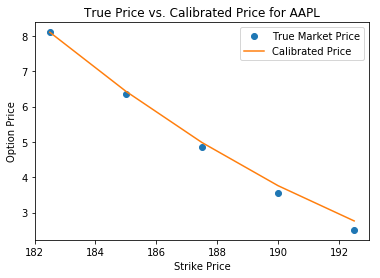

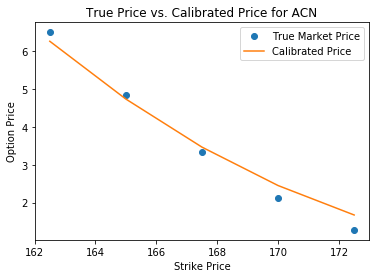

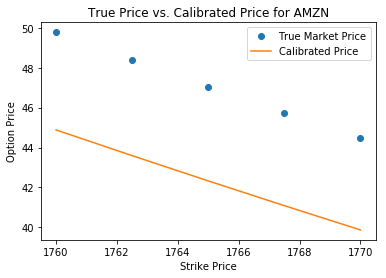

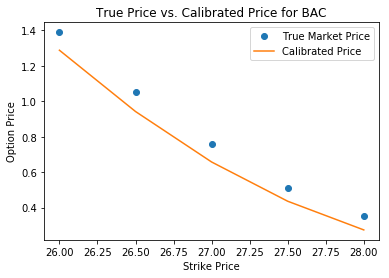

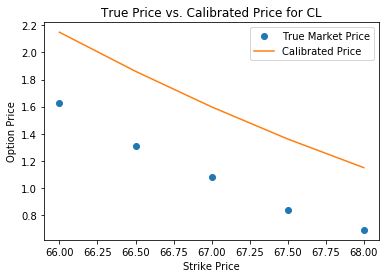

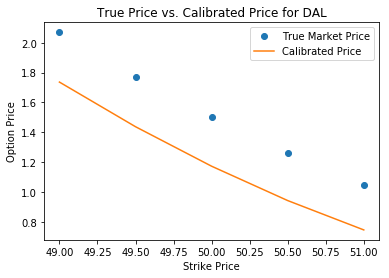

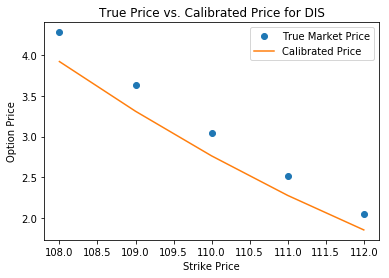

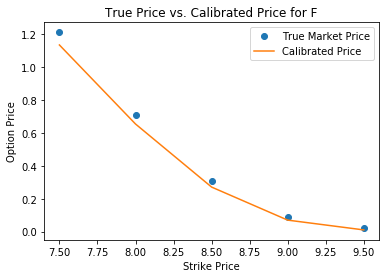

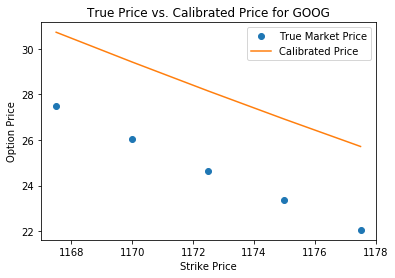

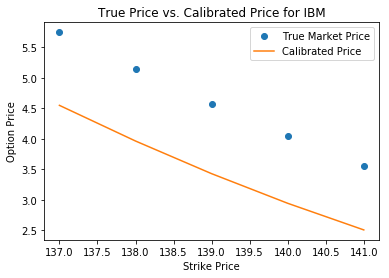

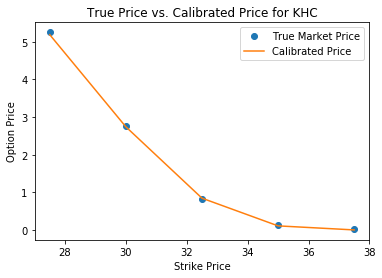

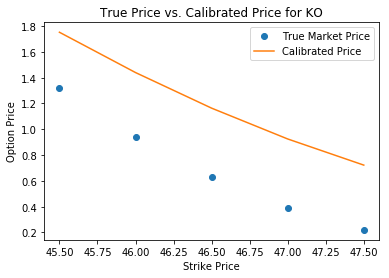

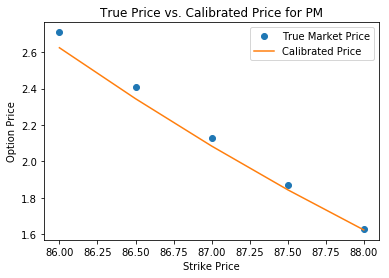

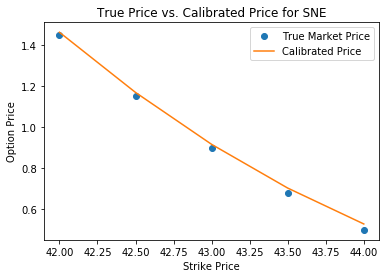

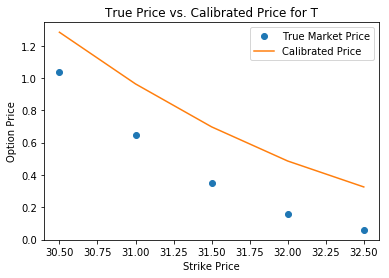

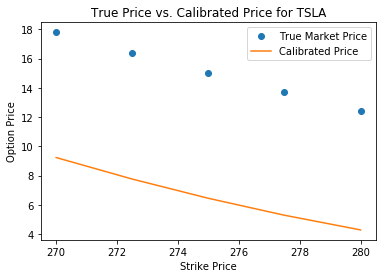

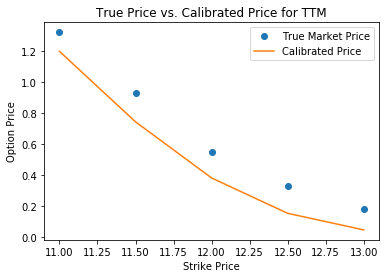

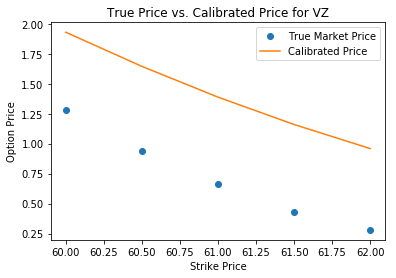

In [16]:
calibration_graphs(strikes,true_prices,option_cal_price_full_set,stock_names,num_data_per_stock)

# Analysis of Initial Calibration

Now we've got something interesting. In all cases the "trend" is being captured, but it's shifted incorrectly for a lot of options. I suspect I know why, but I want to outline it here for clarity (and also to make transcribing this into a presentation easier).

Those stocks whose options are egregiously off-kilter are:

* AMZN (Cal < Mkt)
* CL (Cal > Mkt)
* DAL (Cal < Mkt)
* GOOG (Cal > Mkt)
* IBM (Cal < Mkt)
* KO (Cal > Mkt)
* T (Cal > Mkt)
* TSLA (Cal < Mkt)
* VZ (Cal > Mkt)

For these, we have calibrated volatilties ranging as follows:

* AMZN - 26.4 - 26.6
* CL - 16.19 - 17.13
* DAL - 30.29 - 31.42
* GOOG - 20.51 - 20.74
* IBM - 30.8 - 32.2
* KO - 12.2 - 14.2
* T - 14.6 - 16.3
* TSLA - 54.64 - 57.15
* VZ - 13.39 - 14.7

In every case except for GOOG (and maybe AMZN depending on where the line is drawn), the volatilties of the underlying assets (as depicted on Bloomberg) vastly differed from the calibrated value of about 22.89. I believe that this is the cause for their massive gaps; for AMZN and GOOG, the cause is the fact that they are the only 2 stocks whose spot price was over $\$1,000$ (or, to be even broader, over $\$300$, as the next highest spot price was TSLA...which was ALSO on the list). I'm sure there's a good reason, but more testing and splicing will be required.

I will also note that in all cases, the direction of the shift corresponds with how the calibrated volatility compares to the "true" implied volatility. If the true IV was below the calibrated value of 22.89, the calibrated curve was below the true "curve."

This does raise some good ideas for splices though:

* High-end Volatility Splice: AMZN, DAL, IBM, TSLA
  * A set of stocks whose implied volatilities were above the calibrated value, and whose curve did not trace the points very well
  
* High-end Price Splice: TSLA, AMZN, GOOG (possible secondary splice of just AMZN/GOOG)
  * A set of the 3 stocks with the highest spot price in the set; AMZN and GOOG are also the only 2 stocks with a spot price over $\$1,000$.
  
* Low-end Volatility Splice: CL, KO, T, VZ
  * Same idea as high-end volatility splice, but for those below the curve. I am excluding GOOG from this list because it has true implied volatilities that were very close to the "calibrated" value of $22.89$, and because I feel that it may warrant being an outlier. It could be insightful to do a secondary low-end volatility splice including it as well, to see how it affects performance.
  
* Low-end Price Splice: BAC, F, TTM
  * This last splice is a mirror for the high-end Price Splice, done solely for parity. This does not stem from the above "analysis" but is instead simply picking the 3 stocks with the lowest Spot Price in the set as a foil to the high-end price splice set.
  

Other ideas that could be done, but require more analysis:
* Industry splices
  * Splice based on industry; how, say, would a "basket" of all the tech companies fare?
  * Using Bloomberg, organize by Classification (where multiple in 1 basket)
    * Automobiles: F, TSLA, TTM
    * IT Services: ACN, IBM
    * Telecom Carriers: T, VZ
  * Using Yahoo Finance, organize by Sector (skipping splices done above):
    * Consumer Cyclical: AMZN, DIS, F, TSLA, TTM
    * Consumer Defensive: CL, KHC, KO, PM
    * Technology: AAPL, ACN, GOOG, IBM, SNE
  * Using Yahoo Finance, organize by Industry:
    * Consumer Electronics: AAPL, SNE

# Splice Formation

To form the splices, I will use the `np.concatenate` function on the initial vectors from the Pandas dataframe. For this, I acknowledge the intervals used for each stock:

* AAPL: 0-5
* ACN: 5-10
* AMZN: 10-15
* BAC: 15-20
* CL: 20-25
* DAL: 25-30
* DIS: 30-35
* F: 35-40
* GOOG: 40-45
* IBM: 45-50
* KHC: 50-55
* KO: 55-60
* PM: 60-65
* SNE: 65-70
* T: 70-75
* TSLA: 75-80
* TTM: 80-85
* VZ: 85-90

Note that these are the values which will be used to reference positions in the matrices (as doing a `0:4` interval leaves off the last piece of data in each set).

(For the GBMs and the Num_Data_Per_Stock variables, I instead use their positions in the above list overall in terms of Python counting, i.e. AAPL is 0, ACN is 1, etc.)

With the various splices set up, and all necessary codes pre-defined. It is MUCH easier now to run the process. I just have to feed the relevant info into a handful of functions - the calibration function to produce a volatility, then the price calibration function to make calibrated prices, then the calibrated graph function to draw resulting graphs. In writing the functions above, I have made this much easier for me to run against each splice, reducing their code to 3 lines apiece.

In [0]:
hev_stocks = np.concatenate((stock_names[10:15],stock_names[25:30],stock_names[45:50],stock_names[75:80]))
hev_spots = np.concatenate((spot_prices[10:15],spot_prices[25:30],spot_prices[45:50],spot_prices[75:80]))
hev_strikes = np.concatenate((strikes[10:15],strikes[25:30],strikes[45:50],strikes[75:80]))
hev_prices = np.concatenate((true_prices[10:15],true_prices[25:30],true_prices[45:50],true_prices[75:80]))
hev_iv = np.concatenate((true_iv[10:15],true_iv[25:30],true_iv[45:50],true_iv[75:80]))
hev_gbms = [gbm_list[2],gbm_list[5],gbm_list[9],gbm_list[15]]
hev_options = np.concatenate((option_list[10:15],option_list[25:30],option_list[45:50],option_list[75:80]))
hev_ndps = [num_data_per_stock[2],num_data_per_stock[5],num_data_per_stock[9],num_data_per_stock[15]]
cal_vol_hev = bsm_calibration_data_set_abs(hev_gbms,hev_options,hev_ndps)
cal_price_hev = price_calibration(cal_vol_hev,hev_gbms,hev_options,hev_ndps)


hep_stocks = np.concatenate((stock_names[10:15],stock_names[40:45],stock_names[75:80]))
hep_spots = np.concatenate((spot_prices[10:15],spot_prices[40:45],spot_prices[75:80]))
hep_strikes = np.concatenate((strikes[10:15],strikes[40:45],strikes[75:80]))
hep_prices = np.concatenate((true_prices[10:15],true_prices[40:45],true_prices[75:80]))
hep_iv = np.concatenate((true_iv[10:15],true_iv[40:45],true_iv[75:80]))
hep_gbms = [gbm_list[2],gbm_list[8],gbm_list[15]]
hep_options = np.concatenate((option_list[10:15],option_list[40:45],option_list[75:80]))
hep_ndps = [num_data_per_stock[2],num_data_per_stock[8],num_data_per_stock[15]]
cal_vol_hep = bsm_calibration_data_set_abs(hep_gbms,hep_options,hep_ndps)
cal_price_hep = price_calibration(cal_vol_hep,hep_gbms,hep_options,hep_ndps)


lev_stocks = np.concatenate((stock_names[20:25],stock_names[55:60],stock_names[70:75],stock_names[85:90]))
lev_spots = np.concatenate((spot_prices[20:25],spot_prices[55:60],spot_prices[70:75],spot_prices[85:90]))
lev_strikes = np.concatenate((strikes[20:25],strikes[55:60],strikes[70:75],strikes[85:90]))
lev_prices = np.concatenate((true_prices[20:25],true_prices[55:60],true_prices[70:75],true_prices[85:90]))
lev_iv = np.concatenate((true_iv[20:25],true_iv[55:60],true_iv[70:75],true_iv[85:90]))
lev_gbms = [gbm_list[4],gbm_list[11],gbm_list[14],gbm_list[17]]
lev_options = np.concatenate((option_list[20:25],option_list[55:60],option_list[70:75],option_list[85:90]))
lev_ndps = [num_data_per_stock[4],num_data_per_stock[11],num_data_per_stock[14],num_data_per_stock[17]]
cal_vol_lev = bsm_calibration_data_set_abs(lev_gbms,lev_options,lev_ndps)
cal_price_lev = price_calibration(cal_vol_lev,lev_gbms,lev_options,lev_ndps)


lep_stocks = np.concatenate((stock_names[15:20],stock_names[35:40],stock_names[80:85]))
lep_spots = np.concatenate((spot_prices[15:20],spot_prices[35:40],spot_prices[80:85]))
lep_strikes = np.concatenate((strikes[15:20],strikes[35:40],strikes[80:85]))
lep_prices = np.concatenate((true_prices[15:20],true_prices[35:40],true_prices[80:85]))
lep_iv = np.concatenate((true_iv[15:20],true_iv[35:40],true_iv[80:85]))
lep_gbms = [gbm_list[3],gbm_list[7],gbm_list[16]]
lep_options = np.concatenate((option_list[15:20],option_list[35:40],option_list[80:85]))
lep_ndps = [num_data_per_stock[3],num_data_per_stock[7],num_data_per_stock[16]]
cal_vol_lep = bsm_calibration_data_set_abs(lep_gbms,lep_options,lep_ndps)
cal_price_lep = price_calibration(cal_vol_lep,lep_gbms,lep_options,lep_ndps)


auto_stocks = np.concatenate((stock_names[35:40],stock_names[75:80],stock_names[80:85]))
auto_spots = np.concatenate((spot_prices[35:40],spot_prices[75:80],spot_prices[80:85]))
auto_strikes = np.concatenate((strikes[35:40],strikes[75:80],strikes[80:85]))
auto_prices = np.concatenate((true_prices[35:40],true_prices[75:80],true_prices[80:85]))
auto_iv = np.concatenate((true_iv[35:40],true_iv[75:80],true_iv[80:85]))
auto_gbms = [gbm_list[7],gbm_list[15],gbm_list[16]]
auto_options = np.concatenate((option_list[35:40],option_list[75:80],option_list[80:85]))
auto_ndps = [num_data_per_stock[7],num_data_per_stock[15],num_data_per_stock[16]]
cal_vol_auto = bsm_calibration_data_set_abs(auto_gbms,auto_options,auto_ndps)
cal_price_auto = price_calibration(cal_vol_auto,auto_gbms,auto_options,auto_ndps)


it_stocks = np.concatenate((stock_names[5:10],stock_names[45:50]))
it_spots = np.concatenate((spot_prices[5:10],spot_prices[45:50]))
it_strikes = np.concatenate((strikes[5:10],strikes[45:50]))
it_prices = np.concatenate((true_prices[5:10],true_prices[45:50]))
it_iv = np.concatenate((true_iv[5:10],true_iv[45:50]))
it_gbms = [gbm_list[1],gbm_list[9]]
it_options = np.concatenate((option_list[5:10],option_list[45:50]))
it_ndps = [num_data_per_stock[1],num_data_per_stock[9]]
cal_vol_it = bsm_calibration_data_set_abs(it_gbms,it_options,it_ndps)
cal_price_it = price_calibration(cal_vol_it,it_gbms,it_options,it_ndps)


telecom_stocks = np.concatenate((stock_names[70:75],stock_names[85:90]))
telecom_spots = np.concatenate((spot_prices[70:75],spot_prices[85:90]))
telecom_strikes = np.concatenate((strikes[70:75],strikes[85:90]))
telecom_prices = np.concatenate((true_prices[70:75],true_prices[85:90]))
telecom_iv = np.concatenate((true_iv[70:75],true_iv[85:90]))
telecom_gbms =[gbm_list[14],gbm_list[17]]
telecom_options = np.concatenate((option_list[70:75],option_list[85:90]))
telecom_ndps = [num_data_per_stock[14],num_data_per_stock[17]]
cal_vol_telecom = bsm_calibration_data_set_abs(telecom_gbms,telecom_options,telecom_ndps)
cal_price_telecom = price_calibration(cal_vol_telecom,telecom_gbms,telecom_options,telecom_ndps)


concyc_stocks = np.concatenate((stock_names[10:15],stock_names[30:35],stock_names[35:40],stock_names[75:80],stock_names[80:85]))
concyc_spots = np.concatenate((spot_prices[10:15],spot_prices[30:35],spot_prices[35:40],spot_prices[75:80],spot_prices[80:85]))
concyc_strikes = np.concatenate((strikes[10:15],strikes[30:35],strikes[35:40],strikes[75:80],strikes[80:85]))
concyc_prices = np.concatenate((true_prices[10:15],true_prices[30:35],true_prices[35:40],true_prices[75:80],true_prices[80:85]))
concyc_iv = np.concatenate((true_iv[10:15],true_iv[30:35],true_iv[35:40],true_iv[75:80],true_iv[80:85]))
concyc_gbms = [gbm_list[2],gbm_list[6],gbm_list[7],gbm_list[15],gbm_list[16]]
concyc_options = np.concatenate((option_list[10:15],option_list[30:35],option_list[35:40],option_list[75:80],option_list[80:85]))
concyc_ndps = [num_data_per_stock[2],num_data_per_stock[7],num_data_per_stock[7],num_data_per_stock[15],num_data_per_stock[16]]
cal_vol_concyc = bsm_calibration_data_set_abs(concyc_gbms,concyc_options,concyc_ndps)
cal_price_concyc = price_calibration(cal_vol_concyc,concyc_gbms,concyc_options,concyc_ndps)


condef_stocks = np.concatenate((stock_names[20:25],stock_names[50:55],stock_names[55:60],stock_names[60:65]))
condef_spots = np.concatenate((spot_prices[20:25],spot_prices[50:55],spot_prices[55:60],spot_prices[60:65]))
condef_strikes = np.concatenate((strikes[20:25],strikes[50:55],strikes[55:60],strikes[60:65]))
condef_prices = np.concatenate((true_prices[20:25],true_prices[50:55],true_prices[55:60],true_prices[60:65]))
condef_iv = np.concatenate((true_iv[20:25],true_iv[50:55],true_iv[55:60],true_iv[60:65]))
condef_gbms = [gbm_list[4],gbm_list[10],gbm_list[11],gbm_list[12]]
condef_options = np.concatenate((option_list[20:25],option_list[50:55],option_list[55:60],option_list[60:65]))
condef_ndps = [num_data_per_stock[4],num_data_per_stock[10],num_data_per_stock[11],num_data_per_stock[12]]
cal_vol_condef = bsm_calibration_data_set_abs(condef_gbms,condef_options,condef_ndps)
cal_price_condef = price_calibration(cal_vol_condef,condef_gbms,condef_options,condef_ndps)


tech_stocks = np.concatenate((stock_names[0:5],stock_names[5:10],stock_names[40:45],stock_names[45:50],stock_names[65:70]))
tech_spots = np.concatenate((spot_prices[0:5],spot_prices[5:10],spot_prices[40:45],spot_prices[45:50],spot_prices[65:70]))
tech_strikes = np.concatenate((strikes[0:5],strikes[5:10],strikes[40:45],strikes[45:50],strikes[65:70]))
tech_prices = np.concatenate((true_prices[0:5],true_prices[5:10],true_prices[40:45],true_prices[45:50],true_prices[65:70]))
tech_iv = np.concatenate((true_iv[0:5],true_iv[5:10],true_iv[40:45],true_iv[45:50],true_iv[65:70]))
tech_gbms = [gbm_list[0],gbm_list[1],gbm_list[8],gbm_list[9],gbm_list[13]]
tech_options = np.concatenate((option_list[0:5],option_list[5:10],option_list[40:45],option_list[45:50],option_list[65:70]))
tech_ndps = [num_data_per_stock[0],num_data_per_stock[1],num_data_per_stock[8],num_data_per_stock[9],num_data_per_stock[13]]
cal_vol_tech = bsm_calibration_data_set_abs(tech_gbms,tech_options,tech_ndps)
cal_price_tech = price_calibration(cal_vol_tech,tech_gbms,tech_options,tech_ndps)


conelec_stocks = np.concatenate((stock_names[10:15],stock_names[25:30],stock_names[45:50],stock_names[75:80]))
conelec_spots = np.concatenate((spot_prices[10:15],spot_prices[25:30],spot_prices[45:50],spot_prices[75:80]))
conelec_strikes = np.concatenate((strikes[10:15],strikes[25:30],strikes[45:50],strikes[75:80]))
conelec_prices = np.concatenate((true_prices[10:15],true_prices[25:30],true_prices[45:50],true_prices[75:80]))
conelec_iv = np.concatenate((true_iv[10:15],true_iv[25:30],true_iv[45:50],true_iv[75:80]))
conelec_gbms = [gbm_list[2],gbm_list[5],gbm_list[9],gbm_list[15]]
conelec_options = np.concatenate((option_list[10:15],option_list[25:30],option_list[45:50],option_list[75:80]))
conelec_ndps = [num_data_per_stock[2],num_data_per_stock[5],num_data_per_stock[9],num_data_per_stock[15]]
cal_vol_conelec = bsm_calibration_data_set_abs(conelec_gbms,conelec_options,conelec_ndps)
cal_price_conelec = price_calibration(cal_vol_conelec,conelec_gbms,conelec_options,conelec_ndps)

For each of my chosen splices, I now have a calibrated price vector. I can create individual calibrated_price() graphs for each splice now. I will opt to make the sets one at a time so I can properly address each one before making a conclusion on this section.

# Graphs for Individual Splices

Again, to minimize output of all the graphs.

Calibrated Volatility for High-End Volatility Splice is 0.2566406250000005


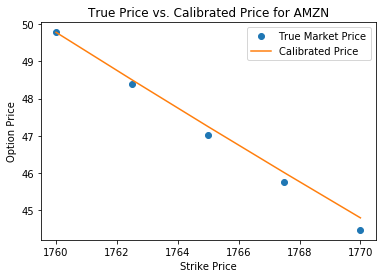

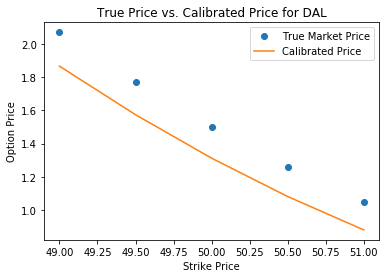

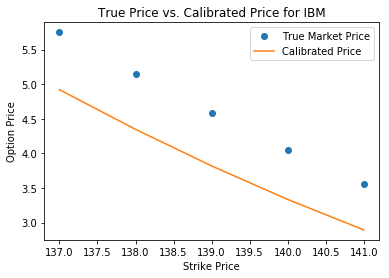

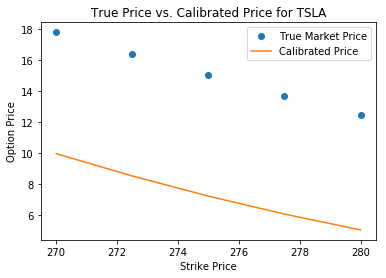

In [18]:
print("Calibrated Volatility for High-End Volatility Splice is " + str(cal_vol_hev))
calibration_graphs(hev_strikes,hev_prices,cal_price_hev,hev_stocks,hev_ndps)

For the high-end volatilities, the splice does a fairly good job of matching the calibrations to the options. The only places it really fails are IBM and TSLA, which both have volatilities that are still above the calibration by significant margins (IBM's volatility ranges from about 30 to about 32%, and TSLA's volatility is well over 50%). The trends are still properly captured, though, even if the scaling is improper.

Calibrated Volatility for High-End Price Splice is 0.2566406250000005


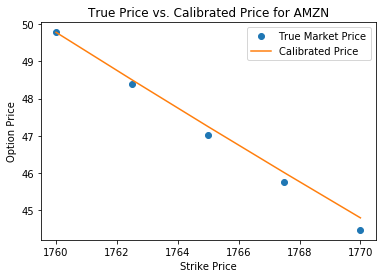

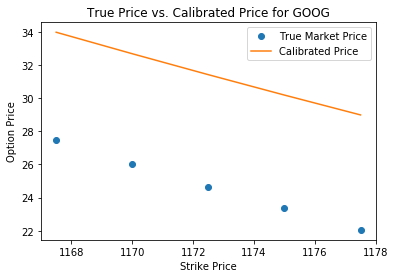

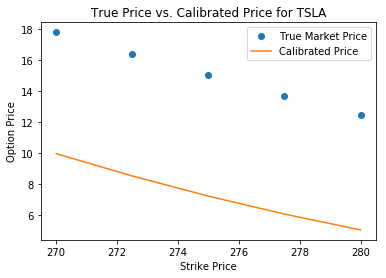

In [19]:
print("Calibrated Volatility for High-End Price Splice is " + str(cal_vol_hep))
calibration_graphs(hep_strikes,hep_prices,cal_price_hep,hep_stocks,hep_ndps)

GOOG and TSLA do not fare well under this splice, likely due to both having volatilities wildly different from the calibrated value. Essentially, at this point it should start to make sense to only splice using stocks with highly similar volatilities (otherwise the calibration will not satisfy everyone and leave some predictions wildly off-kilter).

Calibrated Volatility for Low-End Volatility Splice is 0.14585937500000018


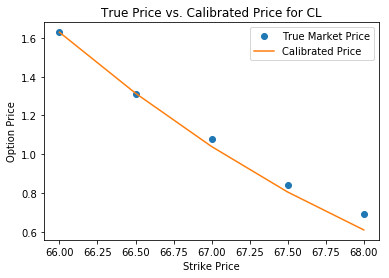

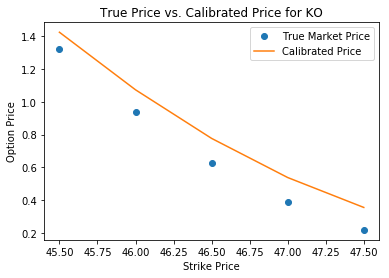

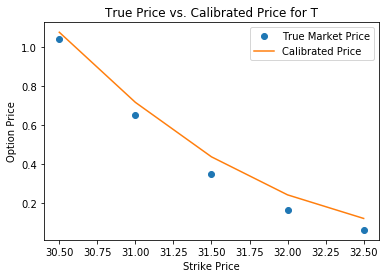

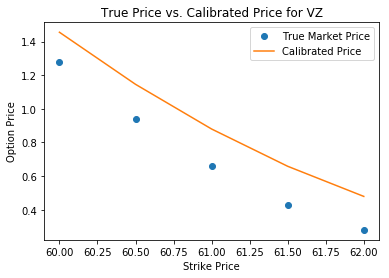

In [20]:
print("Calibrated Volatility for Low-End Volatility Splice is " + str(cal_vol_lev))
calibration_graphs(lev_strikes,lev_prices,cal_price_lev,lev_stocks,lev_ndps)

This calibration does a much better job than the past two, as the spread of volatilities is already small on this end by comparison (and there are no massive outliers like TSLA to throw a wrench into the system).

Calibrated Volatility for Low-End Price Splice is 0.27570312500000066


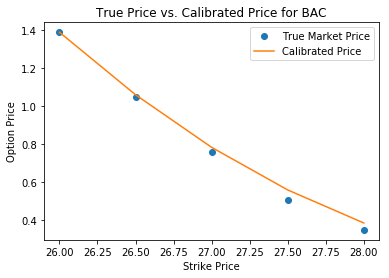

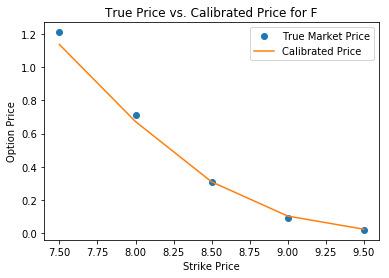

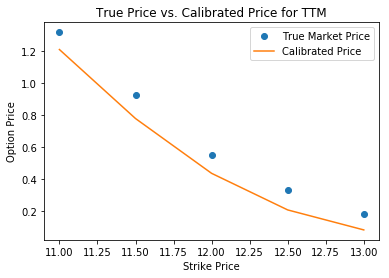

In [21]:
print("Calibrated Volatility for Low-End Price Splice is " + str(cal_vol_lep))
calibration_graphs(lep_strikes,lep_prices,cal_price_lep,lep_stocks,lep_ndps)

Despite volatilities that are all over the place, these stocks actually are calibrated surprisingly well, which shoots down my potential explanation for why the other stocks are "broken" being solely on their volatilities.

Calibrated Volatility for Automotive Class Splice is 0.5253125000000014


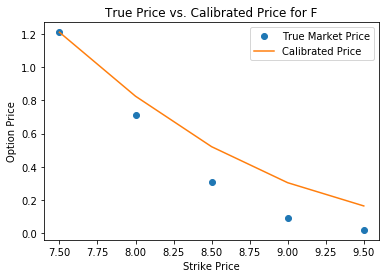

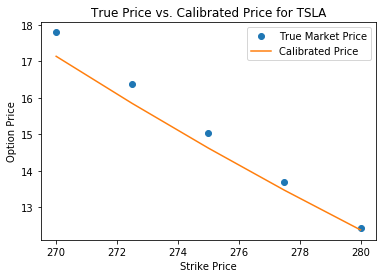

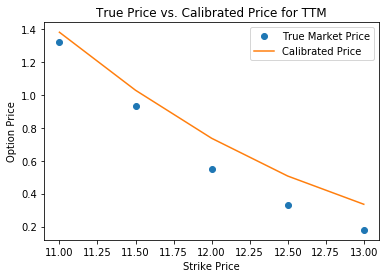

In [22]:
print("Calibrated Volatility for Automotive Class Splice is " + str(cal_vol_auto))
calibration_graphs(auto_strikes,auto_prices,cal_price_auto,auto_stocks,auto_ndps)

For once, TSLA is being properly calibrated; all it took was using Bloomberg to group the stocks for me, in a sense.

Calibrated Volatility for IT Services Class Splice is 0.24476562500000051


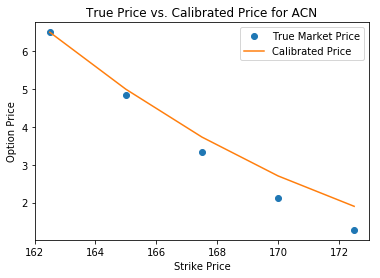

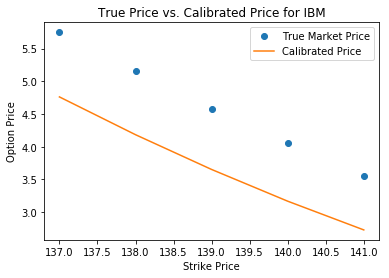

In [23]:
print("Calibrated Volatility for IT Services Class Splice is " + str(cal_vol_it))
calibration_graphs(it_strikes,it_prices,cal_price_it,it_stocks,it_ndps)

Even in a 2-stock model, IBM just can't seem to catch a break. I'm going to assume that what's going on here and in the rest of the models is possibly due to how I came up with the prices I used as "true" prices (that being the average of the bid/ask from end-of-day reports on the 27th of March). I'll have to discuss this in my presentation and my paper but that's an issue for later.

Calibrated Volatility for Telecom Class Splice is 0.1286718750000001


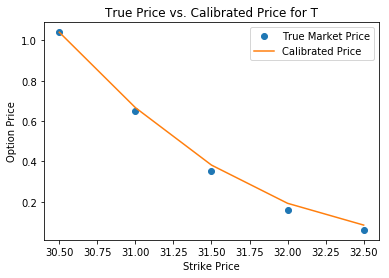

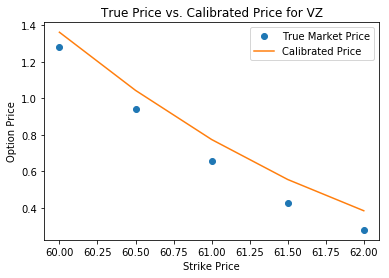

In [24]:
print("Calibrated Volatility for Telecom Class Splice is " + str(cal_vol_telecom))
calibration_graphs(telecom_strikes,telecom_prices,cal_price_telecom,telecom_stocks,telecom_ndps)

T and VZ both fare very well under their solo calibration.

Calibrated Volatility for Consumer Cyclical Sector Splice is 0.2566406250000005


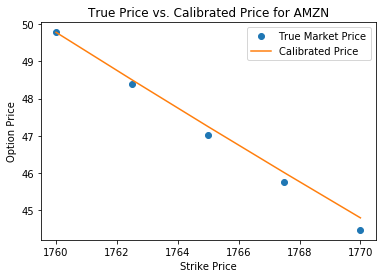

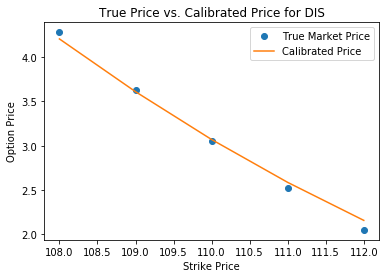

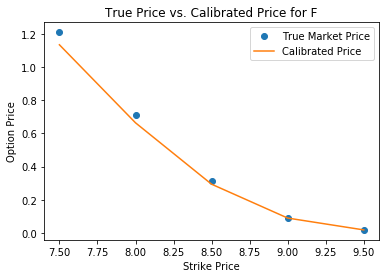

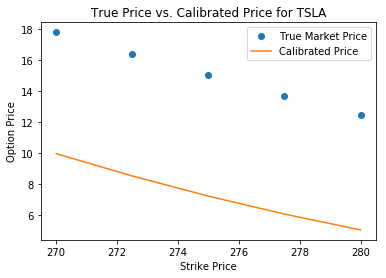

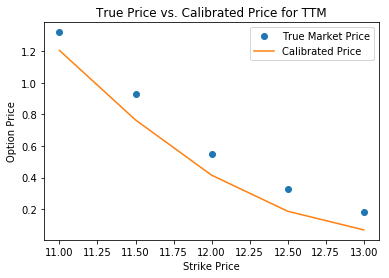

In [25]:
print("Calibrated Volatility for Consumer Cyclical Sector Splice is " + str(cal_vol_concyc))
calibration_graphs(concyc_strikes,concyc_prices,cal_price_concyc,concyc_stocks,concyc_ndps)

TSLA is back to being off-balance again; otherwise not much to report.

Calibrated Volatility for Consumer Defensive Sector Splice is 0.14585937500000018


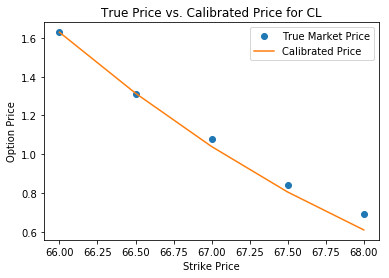

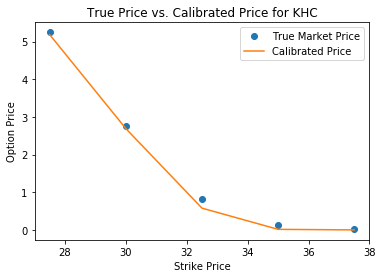

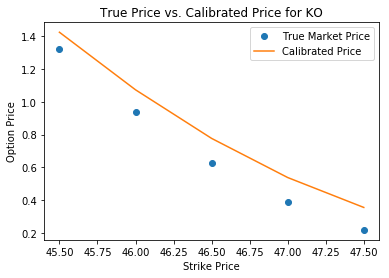

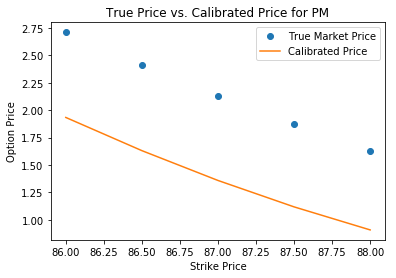

In [26]:
print("Calibrated Volatility for Consumer Defensive Sector Splice is " + str(cal_vol_condef))
calibration_graphs(condef_strikes,condef_prices,cal_price_condef,condef_stocks,condef_ndps)

Under this Consumer Defensive grouping, PM is suddenly doing much worse than it did in the overall calibration, which goes to show that fewer points doesn't always make for a better calibration.

Calibrated Volatility for Technology Sector Splice is 0.22890625000000048


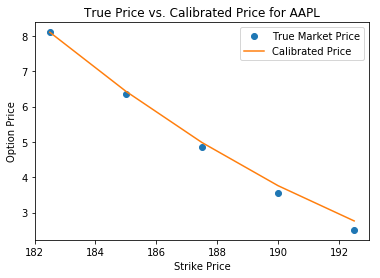

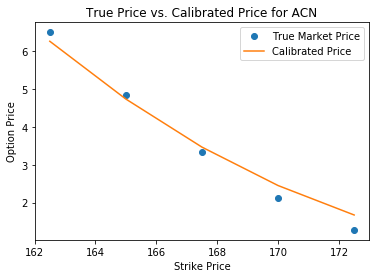

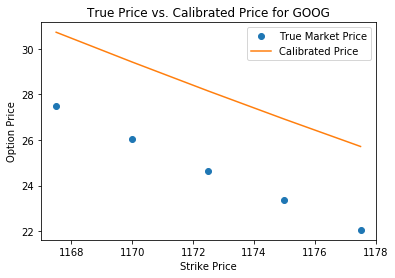

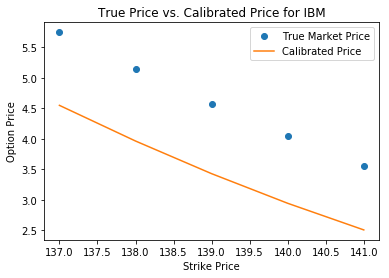

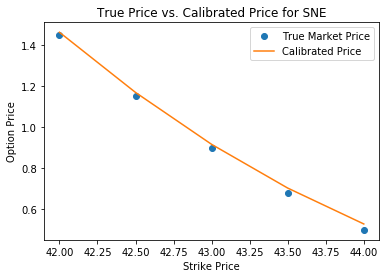

In [27]:
print("Calibrated Volatility for Technology Sector Splice is " + str(cal_vol_tech))
calibration_graphs(tech_strikes,tech_prices,cal_price_tech,tech_stocks,tech_ndps)

GOOG and IBM continue to fare poorly under calibration.

Calibrated Volatility for Consumer Electronics Industry Splice is 0.2566406250000005


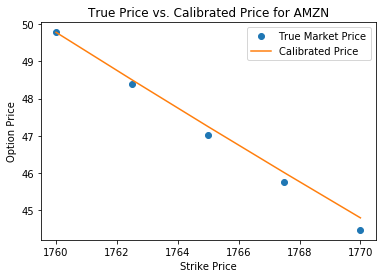

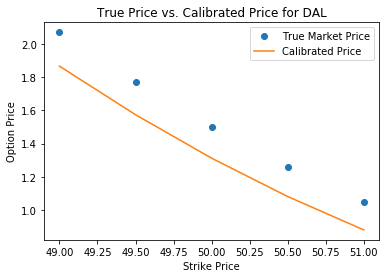

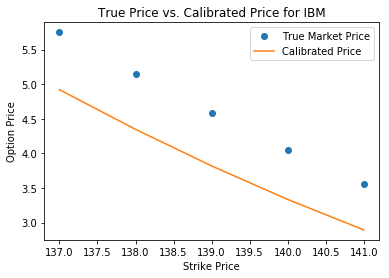

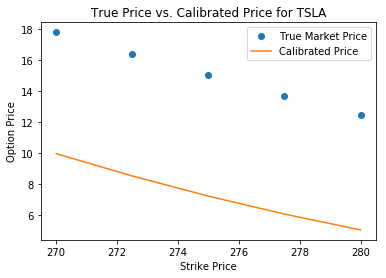

In [28]:
print("Calibrated Volatility for Consumer Electronics Industry Splice is " + str(cal_vol_conelec))
calibration_graphs(conelec_strikes,conelec_prices,cal_price_conelec,conelec_stocks,conelec_ndps)

TSLA once more decides it doesn't want to be calibrated properly. I honestly almost want to consider its one "good" calibration as a fluke at this point, if I'm going to joke about it.

# Overall Conclusions

Initially, the splices seem interesting. Some splices allow stocks to perform better, like TSLA, but others continue to show them working poorly...like TSLA.

I believe this should be a good point to "wrap up" the initial calibration, unless I decide additional splices are required (or I decide to make a TSLA-only splice to see if that can manage to un-break it for once).

# Phase 3: Exotic Options

Now, consider the Exotic options. I will opt to use the Geometric Asian Call, which I can price directly via a definition in my GBM class (I added the GAC to it shortly after that homework assignment, so I can simply reach in and pull it out for the price). I used Bloomberg's Option Valuation Tool (I believe OVT or something in a terminal) to price the options; based on my choice of definition (a daily analysis of the stock's price) and the fact that the markets are closed on the weekends, I will define `num_step = 16`. Now, import the data.

However, there is a caveat. When I was pricing these options, I opted to price them at every strike used in the original set. However, the pricing engine on Bloomberg yielded a price of $\$0.00$ for some options. Those were removed, causing some stocks to only have 4 options listed. This will be a true test of the Num_data_per_set vector, and my code's ability to properly handle a dataset with non-uniform splits of options.

In [0]:
df = pd.read_csv('exotic_options_4_18_19.csv')

exo_stock_names = df.Stock
exo_spot_prices = df['Spot Price']
exo_strikes = df.Strike
exo_true_prices = df['Average Price']
exo_true_iv = df['Average IV']

num_step = 21 # For use in the model

Now, treat the data the same way we (initially) treated the standard option data.

In [0]:
num_row = exo_stock_names.shape[0]
exo_cal_prices = []
exo_num_data_per_stock = [] # A vector to track how many data points each stock corresponds to
first_line = True
count = 1

for i in range(num_row):
  if first_line == True:
    gbm1 = Gbm(init_state = exo_spot_prices[i],
            drift_ratio = r,
            vol_ratio = cal_vol_full_set_abs # Use Calibrated Volatility
            ) 
    gao_price = gbm1.bsm_geometric_asian_price(otype,exo_strikes[i],maturity,num_step)
    exo_cal_prices.append(gao_price)
    first_line = False
  elif exo_stock_names[i] != exo_stock_names[i-1]:
    gbm1 = Gbm(init_state = exo_spot_prices[i],
            drift_ratio = r,
            vol_ratio = cal_vol_full_set_abs # Use Calibrated Volatility
            ) 
    gao_price = gbm1.bsm_geometric_asian_price(otype,exo_strikes[i],maturity,num_step)
    exo_cal_prices.append(gao_price)
    exo_num_data_per_stock.append(count)
    count = 1
  else:
    gao_price = gbm1.bsm_geometric_asian_price(otype,exo_strikes[i],maturity,num_step)
    exo_cal_prices.append(gao_price)
    count = count + 1
    continue

# Append the count value for the final set in the data, which does not get added if the
# last element in the set isn't uniqueas it does not trigger the elif condition 
# regardless of whether the last element is unique or part of a set. If unique, the
# Last element in this array should be 1; otherwise, it is the most updated count.
# In either case, this is the `count` variable.
exo_num_data_per_stock.append(count) 

# Graphing Calibrated Exotic Option Prices

With the "calibrated" exotic options prices now formed, graph the system.

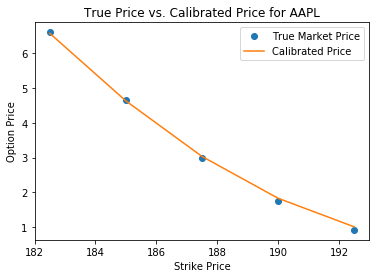

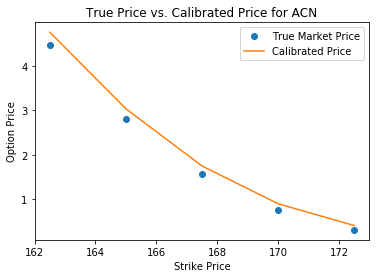

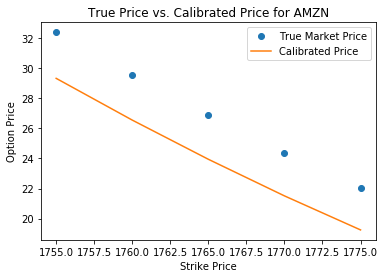

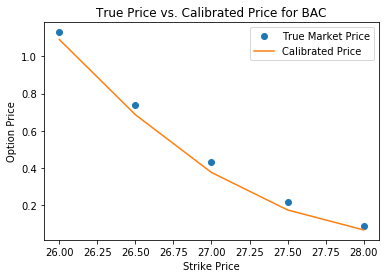

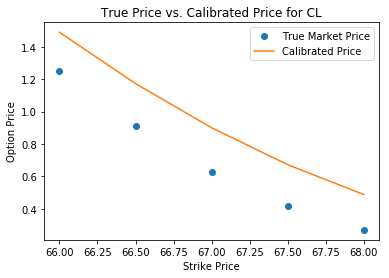

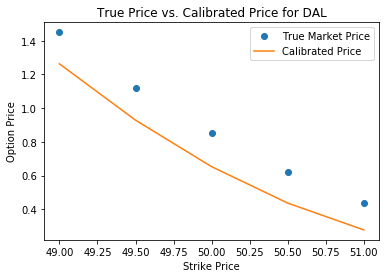

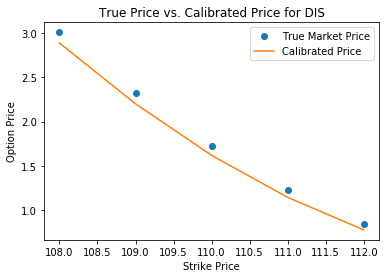

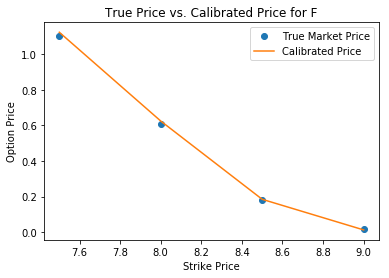

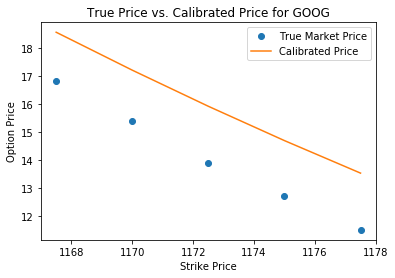

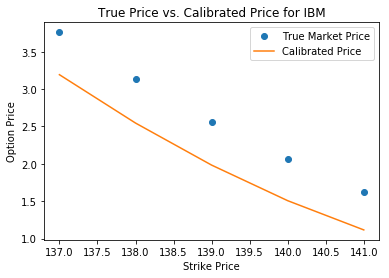

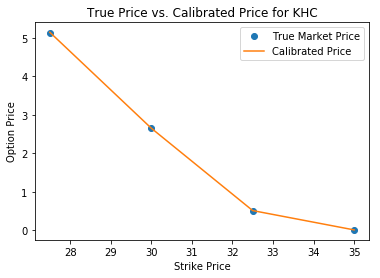

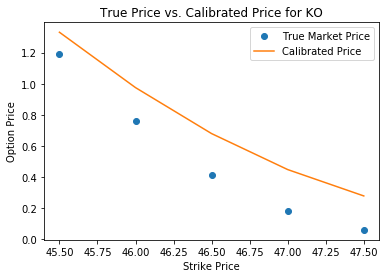

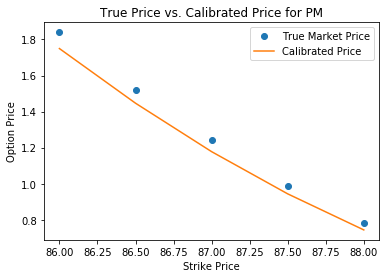

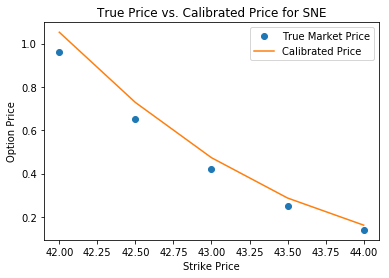

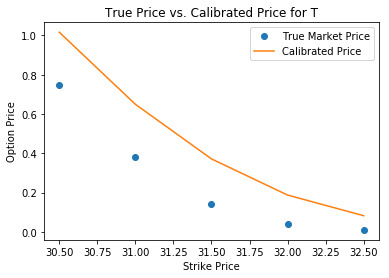

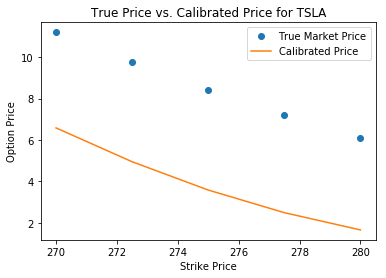

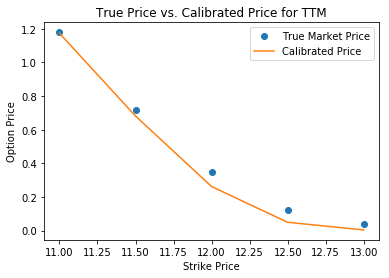

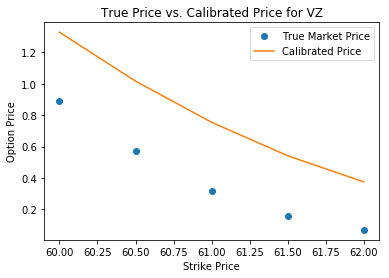

In [22]:
calibration_graphs(exo_strikes,exo_true_prices,exo_cal_prices,exo_stock_names,exo_num_data_per_stock)

While a significant portion of the stocks are still not fitting, I must note something very key here:

The stocks that are having issues now are the same ones which had issues under the calibration for "normal" options.

AMZN, CL, DAL, GOOG, IBM, KO, T, TSLA, and VZ are the ones which are shifted off significantly here. They were the exact same set which were shifted off under normal circumstances.

Thus, I believe my pricing engine is handling this calibration quite admirably. The issue then is either in my code somewhere (and my choice of stocks, which I do believe is a root issue) or in Bloomberg and the market's valuation of some of these options (i.e. an error in their implied volatility calculations, or an error in my interpretation of the prices as presented on their site).

In [0]:
'''=============
This isn't used in the final result; it's just a way to compute multiple IVs from a subset of data.
============='''

def bsm_calibration_data_sub_set_abs(gbm_list,option_list,num_data_per_stock):
  ndps = num_data_per_stock #Simplify name within code body for easier typing.
  num_opts = len(option_list)
  num_gbms = len(gbm_list)
  init_vol = .1 #Initial Guess
  
  # Create empty matrices for IVs.
  iv_abs = np.zeros(num_gbms)
  
  # Create empty matrix for temp storage of Options.
  temp_opt_list = []
  
  ndps_step = 0
  count = 1
  
  for i in range(num_opts):
    temp_opt_list.append(option_list[i])
    if count == ndps[ndps_step]:
      iv_abs[ndps_step] = so.fmin(error_function_abs, init_vol,
                                 args = (gbm_list[ndps_step], temp_opt_list),
                                 disp = 0)[0]
      temp_opt_list = []
      ndps_step = ndps_step + 1
      count = 1
    if count != ndps[ndps_step]:
      count = count + 1
  return iv_abs